In [ ]:
import torch as tc
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
seed = 42
tc.manual_seed(seed)
np.random.seed(seed)
device = 'cuda' if tc.cuda.is_available() else 'cpu'
print(f"Using {device}")

epochs = 160
batch_size = 128
lr = 1e-4
betas = (0.5, 0.999)

Using cuda


# Wasserstein GAN (WGAN)
+ The WGAN represents a significant step forward in the design of GANs, addressing some of the fundamental issues found in the original formulation. By using a more stable metric and eliminating problematic components of the loss function, WGANs generally offer more stable training and improved output diversity, mitigating common issues such as mode collapse.
+ See the course's theory for the Wasserstein distance.
+ Changes take place only in the end regarding our loss objective and functions. The rest is kept the same:

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), noise_shape=(100,)):
        super().__init__()

        self.noise_shape = noise_shape
        self.noise_dim = np.prod(noise_shape)
        self.data_shape = input_shape

        channels = [self.noise_dim, 512, 256, 128, 64, 1]
        kernel_sizes = [4, 4, 3, 3, 4]
        strides = [1, 2, 2, 2, 1]
        paddings = [0, 1, 1, 1, 2]
        activations = [nn.PReLU() for _ in channels[1:]]
        activations.append(nn.Tanh())

        layers = []
        for i in range(len(channels) - 1):
            layers.append(
                nn.ConvTranspose2d(
                    in_channels=channels[i],
                    out_channels=channels[i+1],
                    kernel_size=kernel_sizes[i],
                    stride=strides[i],
                    padding=paddings[i],
                    bias=False
                )
            )
            if i < len(channels) - 2:  # No batch norm or activation after the last Conv layer
                layers.append(nn.BatchNorm2d(num_features=channels[i+1]))
                layers.append(activations[i])

        self.generator = nn.Sequential(*layers)

    def forward(self, noise):
        noise = noise.view(-1, self.noise_dim, 1, 1)
        return self.generator(noise).view(-1, *self.data_shape)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super().__init__()

        self.data_shape = input_shape

        channels = [1, 64, 128, 256, 512, 1]
        kernel_sizes = [4, 3, 3, 4, 4]
        strides = [1, 2, 2, 2, 2]
        paddings = [2, 1, 1, 1, 0]
        use_batch_norm = [False, True, True, True, False]

        layers = []
        for i in range(len(channels) - 1):
            layers.append(
                nn.Conv2d(
                    in_channels=channels[i],
                    out_channels=channels[i+1],
                    kernel_size=kernel_sizes[i],
                    stride=strides[i],
                    padding=paddings[i],
                    bias=False
                )
            )
            if use_batch_norm[i]:
                layers.append(nn.BatchNorm2d(num_features=channels[i+1]))
            layers.append(nn.PReLU())

        # Combine all layers into a sequential model
        self.discriminator = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, *self.data_shape)
        return self.discriminator(x).view(-1, 1)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [ ]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
train_set = MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

data_shape = (1, 28, 28)
noise_dim = 100

In [ ]:
gen = Generator(input_shape=data_shape, noise_shape=noise_dim,).to(device)
gen.apply(weights_init)
gen(tc.zeros(size=(batch_size, noise_dim), device=device))
opt_gen = Adam(params=gen.parameters(), lr=lr, betas=betas)
_ = summary(model=gen, input_data=tc.zeros(size=(batch_size, noise_dim)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-1              [-1, 512, 4, 4]           819,200
|    └─BatchNorm2d: 2-2                  [-1, 512, 4, 4]           1,024
|    └─PReLU: 2-3                        [-1, 512, 4, 4]           1
|    └─ConvTranspose2d: 2-4              [-1, 256, 8, 8]           2,097,152
|    └─BatchNorm2d: 2-5                  [-1, 256, 8, 8]           512
|    └─PReLU: 2-6                        [-1, 256, 8, 8]           1
|    └─ConvTranspose2d: 2-7              [-1, 128, 15, 15]         294,912
|    └─BatchNorm2d: 2-8                  [-1, 128, 15, 15]         256
|    └─PReLU: 2-9                        [-1, 128, 15, 15]         1
|    └─ConvTranspose2d: 2-10             [-1, 64, 29, 29]          73,728
|    └─BatchNorm2d: 2-11                 [-1, 64, 29, 29]          128
|    └─PReLU: 2-12                       [-1, 64, 29, 29]    

In [ ]:
disc = Discriminator(input_shape=data_shape).to(device)
disc.apply(weights_init)
opt_disc = Adam(params=disc.parameters(), lr=lr, betas=betas)
_ = summary(model=disc, input_data=tc.zeros(size=(batch_size, np.prod(data_shape))))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 1, 1]             --
|    └─Conv2d: 2-1                       [-1, 64, 29, 29]          1,024
|    └─PReLU: 2-2                        [-1, 64, 29, 29]          1
|    └─Conv2d: 2-3                       [-1, 128, 15, 15]         73,728
|    └─BatchNorm2d: 2-4                  [-1, 128, 15, 15]         256
|    └─PReLU: 2-5                        [-1, 128, 15, 15]         1
|    └─Conv2d: 2-6                       [-1, 256, 8, 8]           294,912
|    └─BatchNorm2d: 2-7                  [-1, 256, 8, 8]           512
|    └─PReLU: 2-8                        [-1, 256, 8, 8]           1
|    └─Conv2d: 2-9                       [-1, 512, 4, 4]           2,097,152
|    └─BatchNorm2d: 2-10                 [-1, 512, 4, 4]           1,024
|    └─PReLU: 2-11                       [-1, 512, 4, 4]           1
|    └─Conv2d: 2-12                      [-1, 1, 1, 1]           

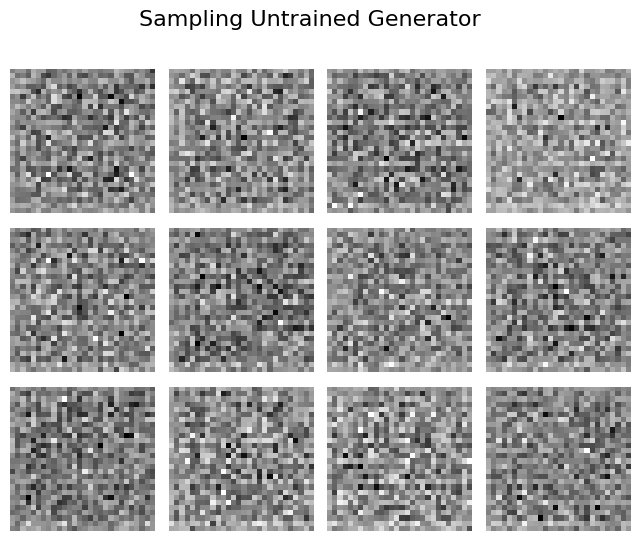

In [ ]:
def generate(n_samples, title):
    # Inference:
    z = tc.randn(n_samples, noise_dim, device=device)
    x_hat = gen(z).detach().cpu().numpy().reshape(-1, 28, 28)

    # The rest is just plotting:
    n_rows = (n_samples + 3) // 4
    fig, axs = plt.subplots(
        nrows=n_rows,
        ncols=4,
        figsize=(8, 2*n_rows),
        subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False}
    )
    for i, axis in enumerate(axs.flat[:n_samples]):
        axis.imshow(x_hat[i], cmap='binary')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    fig.suptitle(title, fontsize=16)
    plt.show()
    plt.close()

no_samples = 12
generate(no_samples, title="Sampling Untrained Generator")

# Discriminator (Critic) Loss

For the discriminator, often referred to as the "critic" in the context of WGANs, the objective is to maximize the difference between the predictions on real data $x$ and generated data $\hat{x}$:

\begin{equation}
L_D = - \left(\mathbb{E}_{x \sim p_{\text{data}}}\left[ D(x) \right] - \mathbb{E}_{x \sim p_{\text{gen}}}\left[ D(\hat{x}) \right] \right).
\end{equation}

This loss function encourages the discriminator to assign higher scores to real data and low scores to generated data. The discriminator training involves maximizing this expression, effectively minimizing its negative as shown in the code below.

+ Critic Iterations: In the training of WGANs, the critic typically undergoes extra iterations compared to the generator in order to stabilize the training process.

# Generator Loss
For the generator, the objective is to maximize the discriminator's prediction on generated data $\hat{x} = G(z), \ z \sim p_{\text{noise}}$, thus:

\begin{equation}
L_G = -\mathbb{E}_{\hat{x} \sim p_{\text{gen}}} \left[ D(\hat{x}) \right].
\end{equation}

This formulation promotes generated samples $\hat{x}$ that the discriminator evaluates as highly as possible, aiming to make them indistinguishable from real samples.

# Enforcing the Lipschitz Constraint

One crucial aspect of the WGAN is enforcing the Lipschitz constraint on the discriminator (critic). This constraint is necessary to ensure that the Wasserstein distance is computed correctly. The Wasserstein distance, which the WGAN aims to minimize, requires the discriminator to be 1-Lipschitz for a correct computation. This distance metric offers better properties for training GANs, including smoother gradients and less susceptibility to mode collapse. Theoretical guarantees provided by the Wasserstein distance depend on the discriminator being Lipschitz continuous. A function is said to be Lipschitz continuous if there exists a constant $K$ (known as the Lipschitz constant) such that for every pair of points $x$ and $y$ in its domain, the value of the function at these points is bounded by $K$ times the distance between $x$ and $y$:
\begin{equation}
|f(x)-f(y)|\leq K||x-y||.
\end{equation}
For the purposes of WGANs, enforcing a Lipschitz constraint on the critic means ensuring that the critic function does not change too abruptly. This is crucial for the model's theoretical grounding and practical performance. The original WGAN paper proposed clipping the weights of the discriminator to a fixed range $[−c,c]$ to enforce this constraint. Here, we'll use $c = 0.01$.

100%|██████████| 469/469 [00:42<00:00, 10.99it/s]


Epoch [1/160] | Loss D: -4.1354 | Loss G: -0.0039


100%|██████████| 469/469 [00:42<00:00, 10.99it/s]


Epoch [2/160] | Loss D: -4.6440 | Loss G: 0.0000


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [3/160] | Loss D: -4.6396 | Loss G: 0.0021


100%|██████████| 469/469 [00:42<00:00, 10.91it/s]


Epoch [4/160] | Loss D: -4.6646 | Loss G: 0.0011


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [5/160] | Loss D: -4.7010 | Loss G: 0.0037


100%|██████████| 469/469 [00:42<00:00, 10.92it/s]


Epoch [6/160] | Loss D: -4.7060 | Loss G: 0.0038


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [7/160] | Loss D: -4.7077 | Loss G: 0.0038


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [8/160] | Loss D: -4.7078 | Loss G: 0.0036


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [9/160] | Loss D: -4.7077 | Loss G: 0.0036


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [10/160] | Loss D: -4.7078 | Loss G: 0.0035


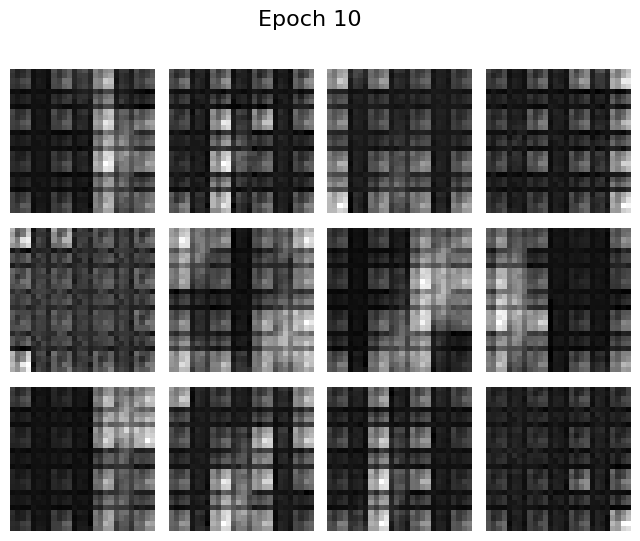

100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [11/160] | Loss D: -4.7077 | Loss G: 0.0034


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [12/160] | Loss D: -4.7076 | Loss G: 0.0034


100%|██████████| 469/469 [00:42<00:00, 10.92it/s]


Epoch [13/160] | Loss D: -4.5706 | Loss G: 0.0002


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [14/160] | Loss D: -4.6847 | Loss G: 0.0029


100%|██████████| 469/469 [00:43<00:00, 10.90it/s]


Epoch [15/160] | Loss D: -4.7056 | Loss G: 0.0038


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [16/160] | Loss D: -4.7083 | Loss G: 0.0039


100%|██████████| 469/469 [00:43<00:00, 10.90it/s]


Epoch [17/160] | Loss D: -4.7081 | Loss G: 0.0037


100%|██████████| 469/469 [00:42<00:00, 10.91it/s]


Epoch [18/160] | Loss D: -4.6599 | Loss G: -0.0003


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [19/160] | Loss D: -4.4624 | Loss G: 0.0015


100%|██████████| 469/469 [00:42<00:00, 10.91it/s]


Epoch [20/160] | Loss D: -4.7123 | Loss G: 0.0037


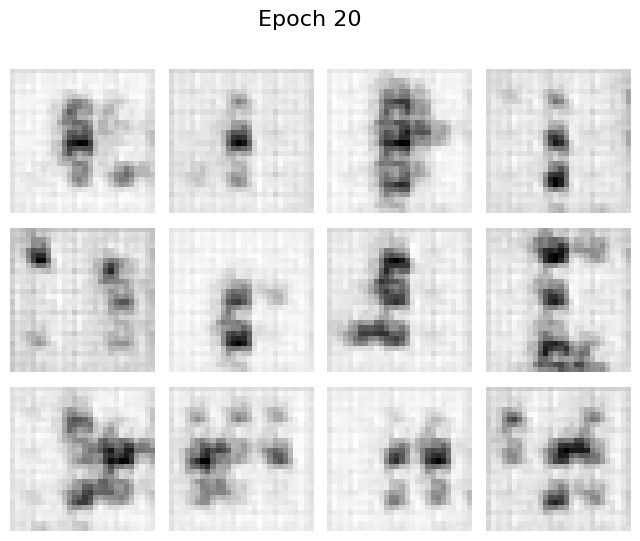

100%|██████████| 469/469 [00:42<00:00, 10.91it/s]


Epoch [21/160] | Loss D: -4.6689 | Loss G: 0.0022


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [22/160] | Loss D: -4.2643 | Loss G: 0.0006


100%|██████████| 469/469 [00:42<00:00, 10.92it/s]


Epoch [23/160] | Loss D: -4.1635 | Loss G: 0.0021


100%|██████████| 469/469 [00:42<00:00, 10.91it/s]


Epoch [24/160] | Loss D: -4.3203 | Loss G: -0.0023


100%|██████████| 469/469 [00:42<00:00, 10.92it/s]


Epoch [25/160] | Loss D: -3.7123 | Loss G: -0.0006


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [26/160] | Loss D: -4.7145 | Loss G: 0.0033


100%|██████████| 469/469 [00:42<00:00, 10.92it/s]


Epoch [27/160] | Loss D: -4.7232 | Loss G: 0.0038


100%|██████████| 469/469 [00:42<00:00, 10.91it/s]


Epoch [28/160] | Loss D: -4.2458 | Loss G: -0.0075


100%|██████████| 469/469 [00:43<00:00, 10.90it/s]


Epoch [29/160] | Loss D: -2.8883 | Loss G: -0.0043


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [30/160] | Loss D: -2.1195 | Loss G: -0.0013


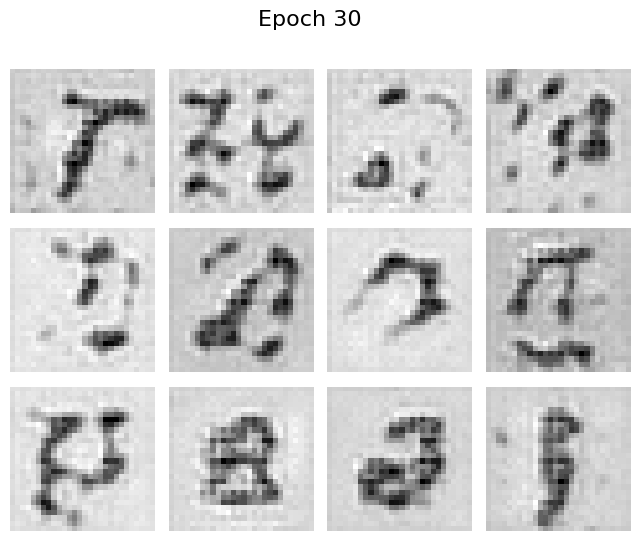

100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [31/160] | Loss D: -2.5093 | Loss G: -0.0054


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [32/160] | Loss D: -2.3886 | Loss G: 0.0015


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [33/160] | Loss D: -2.5042 | Loss G: 0.0001


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [34/160] | Loss D: -1.9876 | Loss G: -0.0073


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [35/160] | Loss D: -3.3584 | Loss G: -0.0027


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [36/160] | Loss D: -3.3737 | Loss G: -0.0026


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [37/160] | Loss D: -3.2838 | Loss G: -0.0093


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [38/160] | Loss D: -4.6209 | Loss G: -0.0005


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [39/160] | Loss D: -4.7197 | Loss G: 0.0032


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [40/160] | Loss D: -4.7294 | Loss G: 0.0037


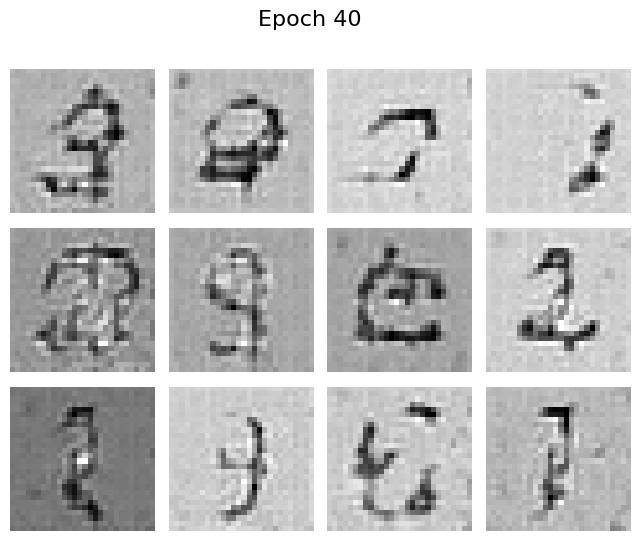

100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [41/160] | Loss D: -4.7341 | Loss G: 0.0039


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [42/160] | Loss D: -4.1137 | Loss G: -0.0224


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [43/160] | Loss D: -2.6804 | Loss G: 0.0028


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [44/160] | Loss D: -2.6316 | Loss G: -0.0210


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [45/160] | Loss D: -3.2603 | Loss G: 0.0025


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [46/160] | Loss D: -3.5387 | Loss G: -0.0206


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [47/160] | Loss D: -4.7445 | Loss G: 0.0033


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [48/160] | Loss D: -4.5157 | Loss G: -0.0091


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [49/160] | Loss D: -4.2564 | Loss G: -0.0001


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [50/160] | Loss D: -4.3927 | Loss G: -0.0035


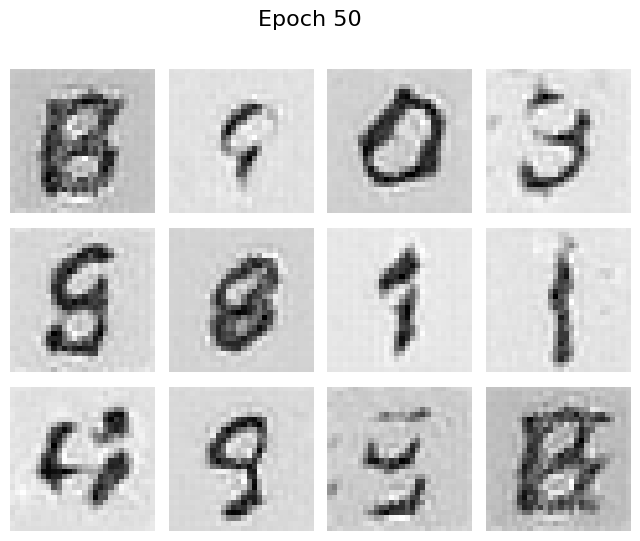

100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [51/160] | Loss D: -4.2855 | Loss G: -0.0070


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [52/160] | Loss D: -4.2548 | Loss G: -0.0071


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [53/160] | Loss D: -4.1840 | Loss G: -0.0089


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [54/160] | Loss D: -4.1960 | Loss G: -0.0102


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [55/160] | Loss D: -4.0491 | Loss G: -0.0144


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [56/160] | Loss D: -4.0002 | Loss G: -0.0170


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [57/160] | Loss D: -3.8135 | Loss G: -0.0251


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [58/160] | Loss D: -3.9297 | Loss G: -0.0249


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [59/160] | Loss D: -3.5713 | Loss G: -0.0389


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [60/160] | Loss D: -3.6751 | Loss G: -0.0377


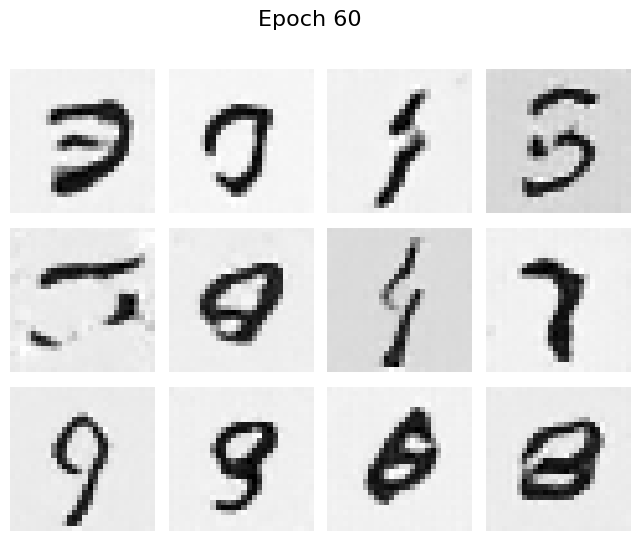

100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [61/160] | Loss D: -3.9676 | Loss G: -0.0324


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [62/160] | Loss D: -4.1387 | Loss G: -0.0300


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [63/160] | Loss D: -3.9464 | Loss G: -0.0361


100%|██████████| 469/469 [00:42<00:00, 10.98it/s]


Epoch [64/160] | Loss D: -3.3328 | Loss G: -0.0729


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [65/160] | Loss D: -3.1822 | Loss G: -0.0821


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [66/160] | Loss D: -2.9507 | Loss G: -0.0923


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [67/160] | Loss D: -2.7572 | Loss G: -0.1079


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [68/160] | Loss D: -2.5804 | Loss G: -0.1328


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [69/160] | Loss D: -2.4519 | Loss G: -0.1372


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [70/160] | Loss D: -2.3304 | Loss G: -0.1665


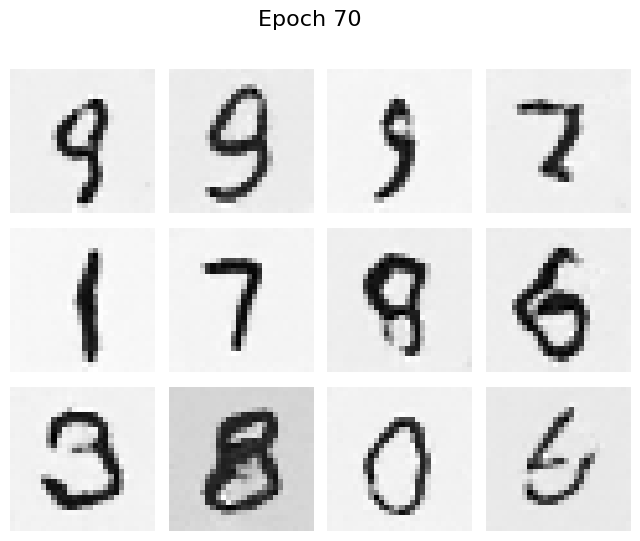

100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [71/160] | Loss D: -2.2723 | Loss G: -0.1554


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [72/160] | Loss D: -2.2390 | Loss G: -0.1502


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [73/160] | Loss D: -2.2027 | Loss G: -0.1601


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [74/160] | Loss D: -2.1171 | Loss G: -0.1648


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [75/160] | Loss D: -2.0607 | Loss G: -0.1657


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [76/160] | Loss D: -2.0331 | Loss G: -0.1580


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [77/160] | Loss D: -2.0140 | Loss G: -0.1636


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [78/160] | Loss D: -1.9608 | Loss G: -0.1740


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [79/160] | Loss D: -1.8980 | Loss G: -0.1791


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [80/160] | Loss D: -1.8265 | Loss G: -0.1914


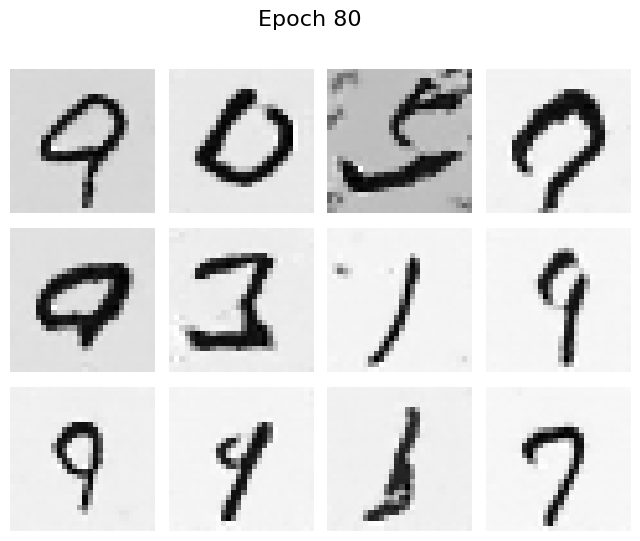

100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [81/160] | Loss D: -1.8307 | Loss G: -0.1616


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [82/160] | Loss D: -1.7967 | Loss G: -0.1875


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [83/160] | Loss D: -1.7715 | Loss G: -0.1828


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [84/160] | Loss D: -1.6589 | Loss G: -0.1990


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [85/160] | Loss D: -1.6569 | Loss G: -0.1830


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [86/160] | Loss D: -1.6223 | Loss G: -0.1895


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [87/160] | Loss D: -1.6281 | Loss G: -0.2002


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [88/160] | Loss D: -1.5982 | Loss G: -0.1905


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [89/160] | Loss D: -1.5406 | Loss G: -0.2109


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [90/160] | Loss D: -1.5144 | Loss G: -0.1957


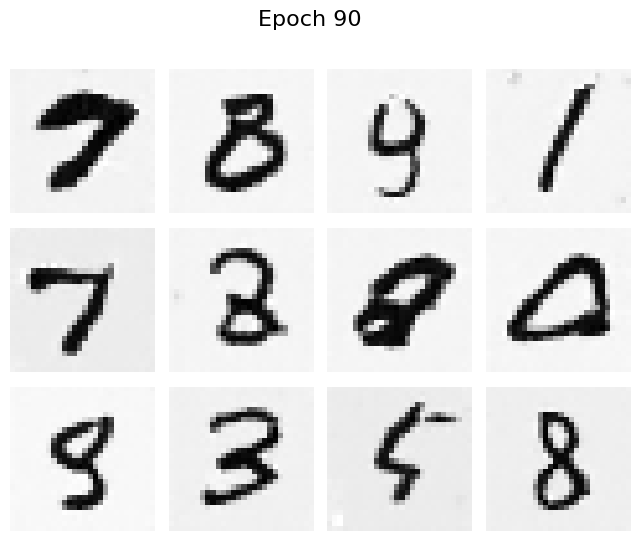

100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [91/160] | Loss D: -1.5184 | Loss G: -0.2016


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [92/160] | Loss D: -1.4845 | Loss G: -0.2066


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [93/160] | Loss D: -1.4327 | Loss G: -0.2197


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [94/160] | Loss D: -1.4333 | Loss G: -0.2090


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [95/160] | Loss D: -1.4290 | Loss G: -0.2118


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [96/160] | Loss D: -1.3864 | Loss G: -0.2107


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [97/160] | Loss D: -1.3747 | Loss G: -0.2171


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [98/160] | Loss D: -1.3820 | Loss G: -0.2191


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [99/160] | Loss D: -1.3378 | Loss G: -0.2288


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [100/160] | Loss D: -1.3650 | Loss G: -0.2015


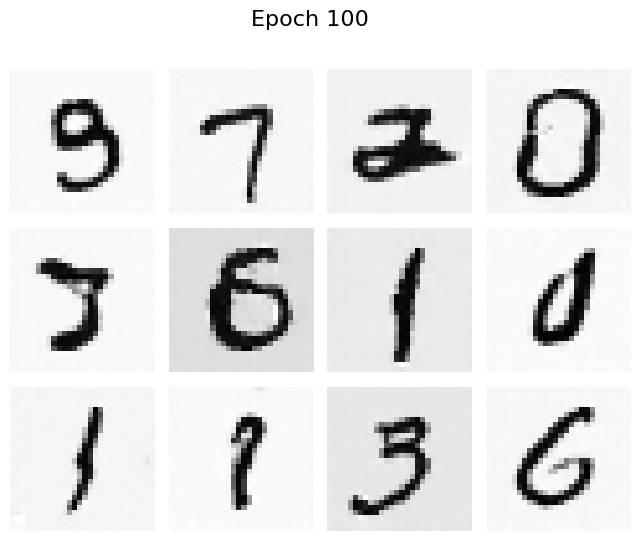

100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [101/160] | Loss D: -1.3200 | Loss G: -0.2176


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [102/160] | Loss D: -1.2838 | Loss G: -0.2399


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [103/160] | Loss D: -1.2736 | Loss G: -0.2292


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [104/160] | Loss D: -1.2586 | Loss G: -0.2285


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [105/160] | Loss D: -1.2588 | Loss G: -0.2229


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [106/160] | Loss D: -1.2419 | Loss G: -0.2230


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [107/160] | Loss D: -1.2312 | Loss G: -0.2152


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [108/160] | Loss D: -1.2094 | Loss G: -0.2295


100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [109/160] | Loss D: -1.2046 | Loss G: -0.2236


100%|██████████| 469/469 [00:42<00:00, 10.97it/s]


Epoch [110/160] | Loss D: -1.1886 | Loss G: -0.2456


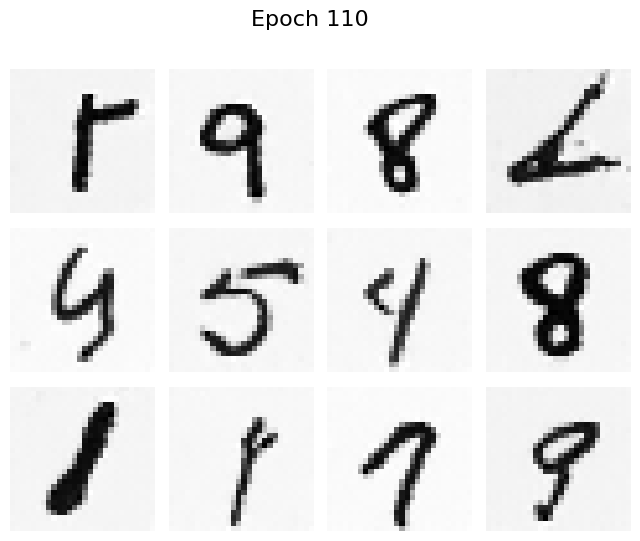

100%|██████████| 469/469 [00:42<00:00, 10.95it/s]


Epoch [111/160] | Loss D: -1.1725 | Loss G: -0.2402


100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Epoch [112/160] | Loss D: -1.1743 | Loss G: -0.2317


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [113/160] | Loss D: -1.1609 | Loss G: -0.2362


100%|██████████| 469/469 [00:42<00:00, 10.96it/s]


Epoch [114/160] | Loss D: -1.1383 | Loss G: -0.2310


100%|██████████| 469/469 [00:42<00:00, 10.94it/s]


Epoch [115/160] | Loss D: -1.1427 | Loss G: -0.2360


100%|██████████| 469/469 [00:43<00:00, 10.87it/s]


Epoch [116/160] | Loss D: -1.1449 | Loss G: -0.2165


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [117/160] | Loss D: -1.1502 | Loss G: -0.2350


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [118/160] | Loss D: -1.1226 | Loss G: -0.2358


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [119/160] | Loss D: -1.1135 | Loss G: -0.2211


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [120/160] | Loss D: -1.0946 | Loss G: -0.2409


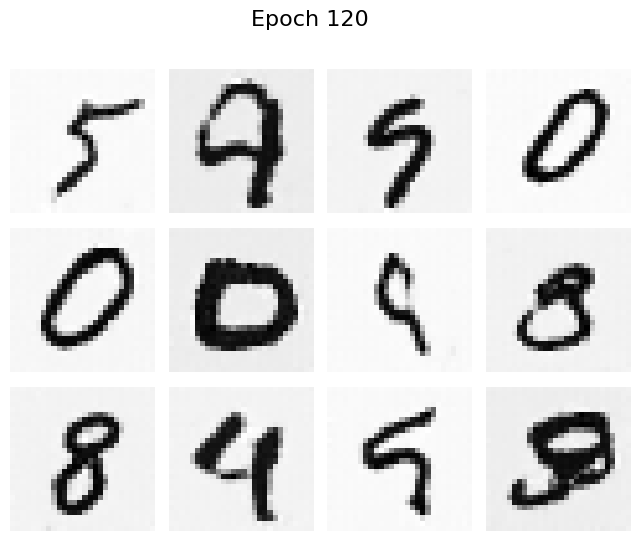

100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [121/160] | Loss D: -1.1042 | Loss G: -0.2302


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [122/160] | Loss D: -1.0862 | Loss G: -0.2368


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


Epoch [123/160] | Loss D: -1.0714 | Loss G: -0.2513


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [124/160] | Loss D: -1.0752 | Loss G: -0.2366


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [125/160] | Loss D: -1.0701 | Loss G: -0.2385


100%|██████████| 469/469 [00:42<00:00, 11.17it/s]


Epoch [126/160] | Loss D: -1.0394 | Loss G: -0.2532


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [127/160] | Loss D: -1.0660 | Loss G: -0.2384


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [128/160] | Loss D: -1.0559 | Loss G: -0.2332


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


Epoch [129/160] | Loss D: -1.0430 | Loss G: -0.2381


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


Epoch [130/160] | Loss D: -1.0322 | Loss G: -0.2403


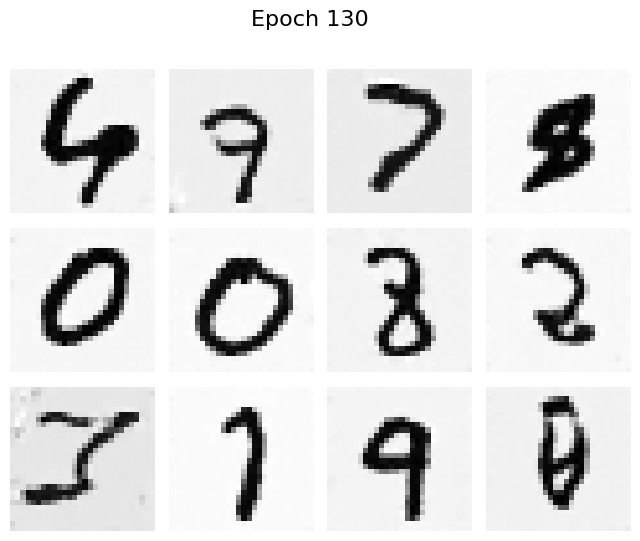

100%|██████████| 469/469 [00:42<00:00, 11.01it/s]


Epoch [131/160] | Loss D: -1.0145 | Loss G: -0.2498


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


Epoch [132/160] | Loss D: -1.0075 | Loss G: -0.2397


100%|██████████| 469/469 [00:42<00:00, 11.16it/s]


Epoch [133/160] | Loss D: -1.0028 | Loss G: -0.2531


100%|██████████| 469/469 [00:41<00:00, 11.18it/s]


Epoch [134/160] | Loss D: -0.9959 | Loss G: -0.2601


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [135/160] | Loss D: -1.0008 | Loss G: -0.2512


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [136/160] | Loss D: -1.0002 | Loss G: -0.2346


100%|██████████| 469/469 [00:41<00:00, 11.18it/s]


Epoch [137/160] | Loss D: -0.9713 | Loss G: -0.2525


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [138/160] | Loss D: -0.9657 | Loss G: -0.2586


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


Epoch [139/160] | Loss D: -0.9688 | Loss G: -0.2452


100%|██████████| 469/469 [00:42<00:00, 11.16it/s]


Epoch [140/160] | Loss D: -0.9599 | Loss G: -0.2385


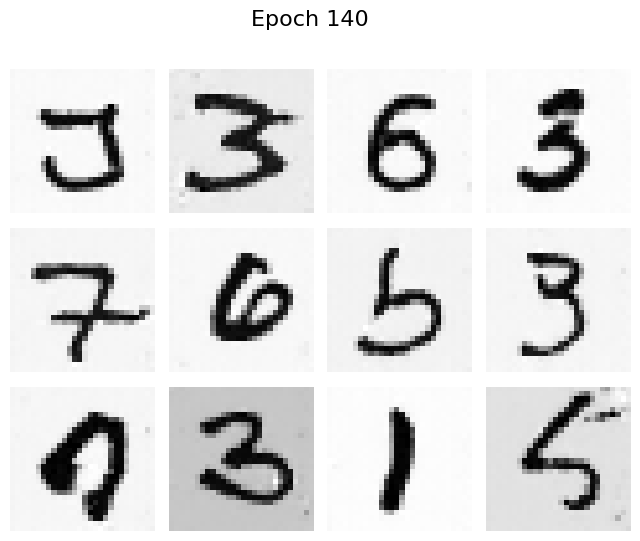

100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [141/160] | Loss D: -0.9637 | Loss G: -0.2392


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [142/160] | Loss D: -0.9467 | Loss G: -0.2353


100%|██████████| 469/469 [00:42<00:00, 11.13it/s]


Epoch [143/160] | Loss D: -0.9460 | Loss G: -0.2548


100%|██████████| 469/469 [00:42<00:00, 11.16it/s]


Epoch [144/160] | Loss D: -0.9289 | Loss G: -0.2540


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [145/160] | Loss D: -0.9382 | Loss G: -0.2437


100%|██████████| 469/469 [00:42<00:00, 11.16it/s]


Epoch [146/160] | Loss D: -0.9247 | Loss G: -0.2424


100%|██████████| 469/469 [00:42<00:00, 11.13it/s]


Epoch [147/160] | Loss D: -0.9258 | Loss G: -0.2447


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [148/160] | Loss D: -0.9087 | Loss G: -0.2497


100%|██████████| 469/469 [00:42<00:00, 11.16it/s]


Epoch [149/160] | Loss D: -0.9122 | Loss G: -0.2456


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [150/160] | Loss D: -0.9105 | Loss G: -0.2484


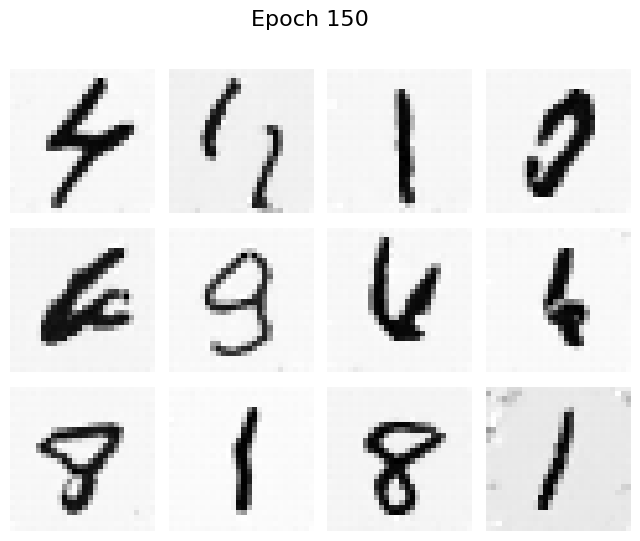

100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


Epoch [151/160] | Loss D: -0.9010 | Loss G: -0.2564


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


Epoch [152/160] | Loss D: -0.8840 | Loss G: -0.2591


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [153/160] | Loss D: -0.8995 | Loss G: -0.2464


100%|██████████| 469/469 [00:41<00:00, 11.17it/s]


Epoch [154/160] | Loss D: -0.8659 | Loss G: -0.2586


100%|██████████| 469/469 [00:42<00:00, 11.14it/s]


Epoch [155/160] | Loss D: -0.8862 | Loss G: -0.2497


100%|██████████| 469/469 [00:42<00:00, 11.15it/s]


Epoch [156/160] | Loss D: -0.8747 | Loss G: -0.2514


100%|██████████| 469/469 [00:43<00:00, 10.82it/s]


Epoch [157/160] | Loss D: -0.8745 | Loss G: -0.2556


100%|██████████| 469/469 [00:43<00:00, 10.73it/s]


Epoch [158/160] | Loss D: -0.8674 | Loss G: -0.2607


100%|██████████| 469/469 [00:43<00:00, 10.75it/s]


Epoch [159/160] | Loss D: -0.8536 | Loss G: -0.2350


100%|██████████| 469/469 [00:42<00:00, 10.92it/s]


Epoch [160/160] | Loss D: -0.8606 | Loss G: -0.2563


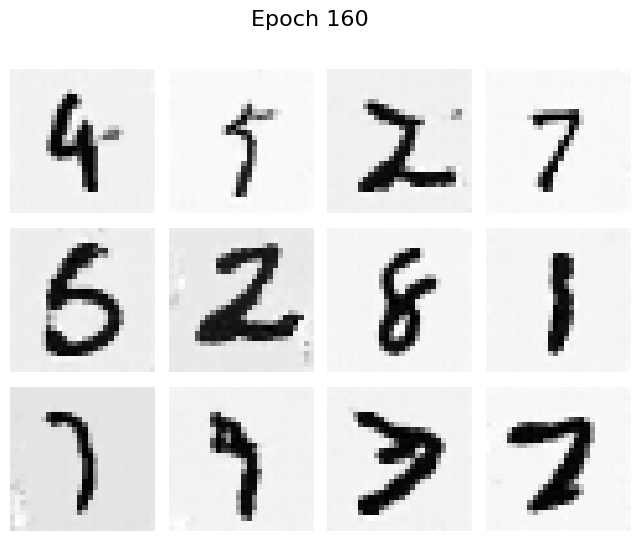

In [ ]:
def train_loop():

    clip_value = 0.01  # Clip value for weights
    critic_iterations = 5

    disc_losses = np.zeros(epochs)
    gen_losses = np.zeros(epochs)
    sample_every = 10
    gen.train()
    disc.train()

    for epoch in range(epochs):

        gen_loss = 0
        disc_loss = 0

        for i, (x, _) in enumerate(tqdm(train_loader)):

            # ------------------------ Train Discriminator: ------------------------
            for _ in range(critic_iterations):

                opt_disc.zero_grad()
                x = x.to(device)
                z = tc.randn(x.shape[0], noise_dim).to(device)
                x_hat = gen(z)

                pred_real = disc(x)
                pred_fake = disc(x_hat)

                # Wasserstein Loss:
                loss_disc = -(tc.mean(pred_real) - tc.mean(pred_fake))
                disc_loss += loss_disc.item()

                loss_disc.backward()
                opt_disc.step()

                # Weight clipping:
                for p in disc.parameters():
                    p.data.clamp_(-clip_value, clip_value)

            # ------------------------ Train Generator: ------------------------
            z = tc.randn(x.shape[0], noise_dim).to(device)
            x_hat = gen(z)
            gen.zero_grad()

            pred_fake = disc(x_hat)

            loss_gen = -tc.mean(pred_fake)

            loss_gen.backward()
            opt_gen.step()

            gen_loss += loss_gen.item()

        # Print:
        disc_losses[epoch] = disc_loss / len(train_loader)
        gen_losses[epoch] = gen_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {disc_losses[epoch]:.4f} | Loss G: {gen_losses[epoch]:.4f}")
        # Sample:
        if (epoch + 1) % sample_every == 0:
            gen.eval()
            generate(no_samples, f"Epoch {epoch + 1}")
            gen.train()

    return disc_losses, gen_losses

d_loss, g_loss = train_loop()

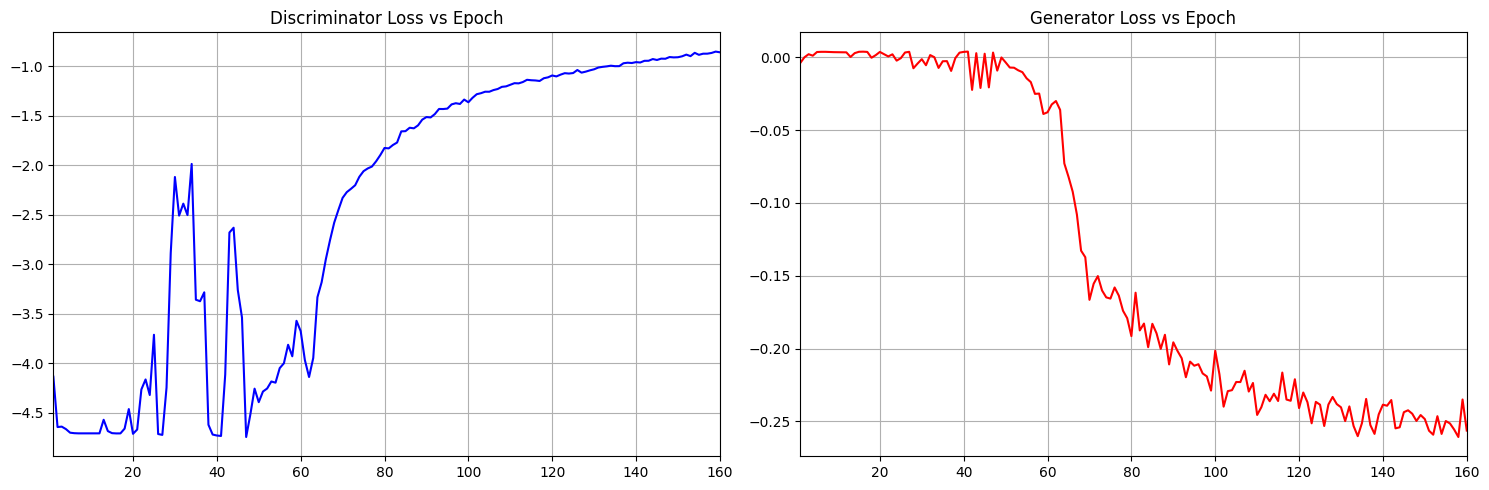

In [ ]:
epoch_ax = np.arange(start=1, stop=epochs+1, step=1)
_, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(epoch_ax, d_loss, color='blue')
ax[0].set_xlim(1, epochs)
ax[0].set_title("Discriminator Loss vs Epoch")
ax[0].grid()

ax[1].plot(epoch_ax, g_loss, color='red')
ax[1].set_xlim(1, epochs)
ax[1].set_title("Generator Loss vs Epoch")
ax[1].grid()

plt.tight_layout()
plt.show()
plt.close()

# An Improvement for WGANs

Enforcing the Lipschitz constraint with weight clipping can affect the capacity of the discriminator. A subsequent improvement, the WGAN with Gradient Penalty (WGAN-GP), proposes an alternative method that adds a penalty term to the loss function for failing to meet a gradient norm of $1$. This method is more effective in practice and helps maintain the theoretical properties of the Wasserstein distance without compromising the model's capacity.  The gradient penalty is typically implemented as:

\begin{equation}
\lambda\left( ||\nabla_{\hat{x}} D(\hat{x})||_2 - 1 \right)^2.
\end{equation}

### Homework (optional)

Change this model to WGAN-GP.